# Response time minimization - South-East police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.


#### South-East police district
The South-East police district includes Vestfold, Telemark and Buskerud (including Jevnaker in Akershus) and is one of the largest police districts in the country, measured by population, with close to 700,000 inhabitants.

In [46]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-17T21:52:52.732461+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

osmnx     : 1.9.1
numpy     : 1.26.4
pandas    : 2.2.1
matplotlib: 3.8.3
geopandas : 0.14.3
pandana   : 0.7



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Network node centrality has been computed and saved locally. Edges contain road speeds and travel times. Road speeds have been increased by 20-40% to simulate police vehicle speeds.

In [48]:
### Load road network from file
SouthEast_filepath = "../data/SouthEast/SouthEastDriveImputed.graphml" # with travel time attribute
SouthEast_graph = ox.load_graphml(SouthEast_filepath) # originally in WGS84 (EPSG:4326)

In [49]:
SouthEast_graph = ox.projection.project_graph(SouthEast_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of SouthEast_graph: {type(SouthEast_graph)}")
print(f"CRS of SouthEast_graph:  {SouthEast_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(SouthEast_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of SouthEast_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of SouthEast_graph:  EPSG:32633


Convert MultiDiGraph to node and edge GeoDataFrames.

In [50]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(SouthEast_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid   lanes   ref highway maxspeed  \
u        v         key                                                         
10302617 10302622  0                533444201       2  E 18   trunk       80   
10302622 836895214 0    [433808498, 70062287]  [2, 1]  E 18   trunk       80   

                        oneway reversed  length  \
u        v         key                            
10302617 10302622  0     False    False 455.109   
10302622 836895214 0      True    False 320.376   

                                                                 geometry  \
u        v         key                                                      
10302617 10302622  0    LINESTRING (170220.120 6542229.281, 170237.170...   
10302622 836895214 0    LINESTRING (170603.539 6542468.624, 170617.119...   

                        speed_kph  travel_time bridge name tunnel junction  \
u        v         key                                                       
10302617 10302622  0       80.000       20.500    NaN  NaN    NaN      NaN   
10302622 836895214 0       80.000       14.400    NaN  NaN    NaN      NaN   

                       access width service est_width  
u        v         key                                 
10302617 10302622  0      NaN   NaN     NaN       NaN  
10302622 836895214 0      NaN   NaN     NaN       NaN

Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [51]:
# increase speed of edges
edges_increased = utilityModule.increase_edge_speeds(edges)
edges_increased.head(2) # verify increased edge speeds and shorter travel times

osmid   lanes   ref highway maxspeed  \
u        v         key                                                         
10302617 10302622  0                533444201       2  E 18   trunk       80   
10302622 836895214 0    [433808498, 70062287]  [2, 1]  E 18   trunk       80   

                        oneway reversed  length  \
u        v         key                            
10302617 10302622  0     False    False 455.109   
10302622 836895214 0      True    False 320.376   

                                                                 geometry  \
u        v         key                                                      
10302617 10302622  0    LINESTRING (170220.120 6542229.281, 170237.170...   
10302622 836895214 0    LINESTRING (170603.539 6542468.624, 170617.119...   

                        speed_kph  travel_time bridge name tunnel junction  \
u        v         key                                                       
10302617 10302622  0      104.525       15.675    NaN  NaN    NaN      NaN   
10302622 836895214 0      104.525       11.034    NaN  NaN    NaN      NaN   

                       access width service est_width  
u        v         key                                 
10302617 10302622  0      NaN   NaN     NaN       NaN  
10302622 836895214 0      NaN   NaN     NaN       NaN

In [52]:
# recombining nodes and increased edges to MultiDiGraph format - obs, careful of project + plot bug
SouthEast_graph_increased = ox.graph_from_gdfs(nodes, edges_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.

In [53]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
SouthEast_polygon_path = "../data/SouthEast/SouthEastCombinedPolygon.geojson"
SouthEast_polygon_gdf = gpd.read_file(SouthEast_polygon_path)
SouthEast_polygon_gdf = SouthEast_polygon_gdf.to_crs(SouthEast_graph.graph['crs']) # convert to same CRS as the road network

In [54]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/SouthEast/SouthEastPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(SouthEast_graph.graph['crs']) # convert to same CRS as the road network

In [55]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  21742506528250           2   
1  21745006528500           1   

                                            geometry  
0  POLYGON ((174410.883 6528249.998, 174411.628 6...  
1  POLYGON ((174500.000 6528500.000, 174500.000 6...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [56]:
# calculate the number of points to simulate in each grid cell - vectorized version
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1000, max_range=1100) # few events, fast testing
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=4300, max_range=4500) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 1020. Target range [1000, 1100], using population multiplier: 0.0033203125000000003


id  population  \
19334  22315006629500        1032   
19473  22312506632250         805   
5242   21912506576750         487   

                                                geometry  num_points  
19334  POLYGON ((231500.000 6629500.000, 231500.000 6...           3  
19473  POLYGON ((231250.000 6632250.000, 231250.000 6...           3  
5242   POLYGON ((191250.000 6576750.000, 191250.000 6...           2

In [57]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

geometry
0  POINT (177702.612 6538645.894)
1  POINT (177358.857 6538536.729)
2  POINT (177410.316 6538851.326)

In [58]:
# create polygons around high event density areas
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, 
                        density_threshold=5.5e-11, simplification_tolerance=5.0, plot_results=False)

Density: Min: 1.906e-25 | Median: 1.342e-12 | Mean: 4.378e-11 | Max: 6.272e-10


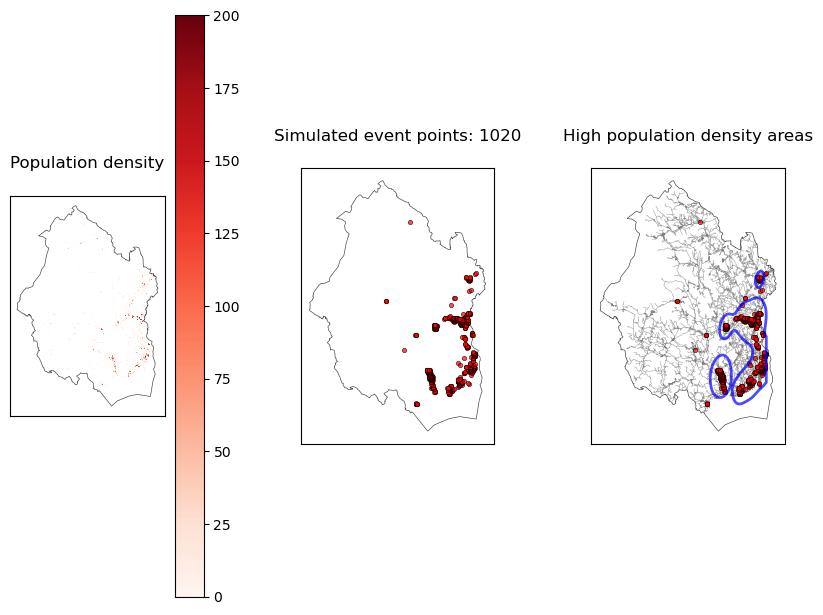

In [59]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(SouthEast_polygon_gdf, population_gdf, 
                                                       event_points_gdf, high_pop_density_area, edges)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [60]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/SouthEast/SouthEastNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count   lon    lat  ref highway  \
osmid                                                                     
10302617 6542229.281 170220.120             3 9.273 58.893  NaN     NaN   
10302622 6542468.624 170603.539             3 9.280 58.895  NaN     NaN   

                                geometry  closeness_centrality  \
osmid                                                            
10302617  POINT (170220.120 6542229.281)                 0.000   
10302622  POINT (170603.539 6542468.624)                 0.000   

          betweenness_centrality  
osmid                             
10302617                   0.000  
10302622              103836.000

### 2.2 Sample candidate points and filter out best candidate points

In [61]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 51953, nr of police car nodes: 100


y          x  street_count    lon    lat  ref highway  \
osmid                                                                        
3834942104 6555863.304 215890.501             3 10.045 59.047  NaN     NaN   
1896241327 6573544.870 232312.424             1 10.309 59.216  NaN     NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
3834942104  POINT (215890.501 6555863.304)                 0.000   
1896241327  POINT (232312.424 6573544.870)                 0.000   

            betweenness_centrality  
osmid                               
3834942104            27922758.500  
1896241327                   0.000

Input nr of car nodes: 100
Remaining nr of car nodes: 80, after discarding the 20 (20%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


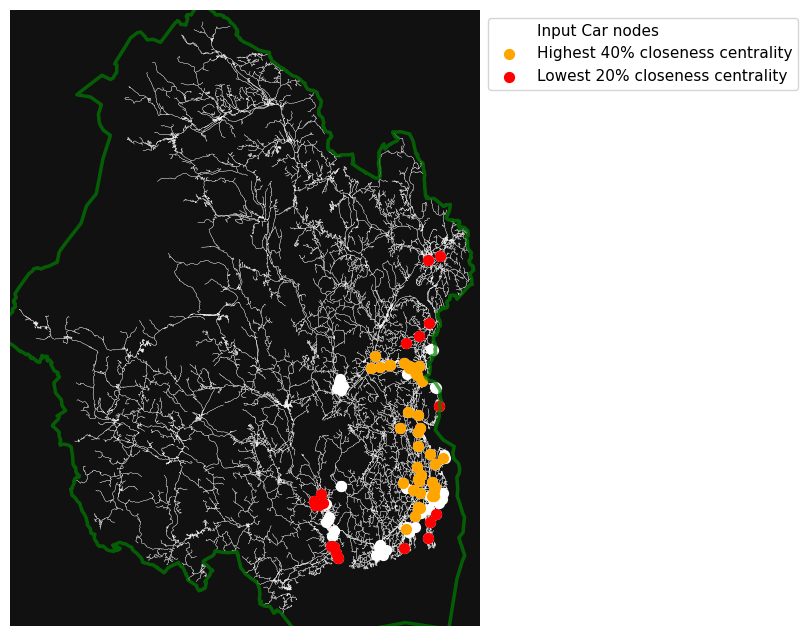

In [62]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=SouthEast_polygon_gdf, 
                    top_percent=0.4, bottom_percent=0.20, input_graph=SouthEast_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 80
Remaining nr of car nodes: 64, after discarding the 16 (20%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


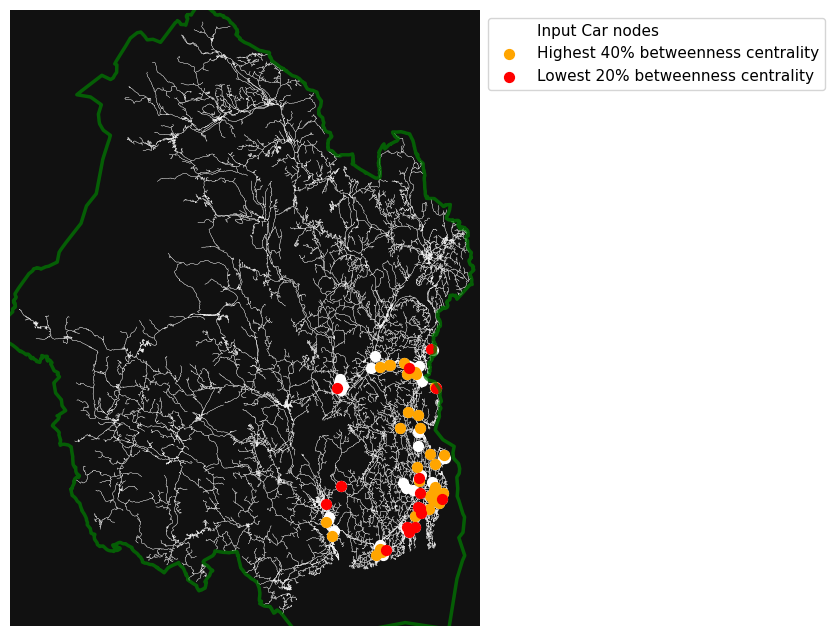

In [63]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=SouthEast_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.20, input_graph=SouthEast_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 64
Remaining nr of car nodes: 43, after removing the 21 nodes that are within 2000 m of each other



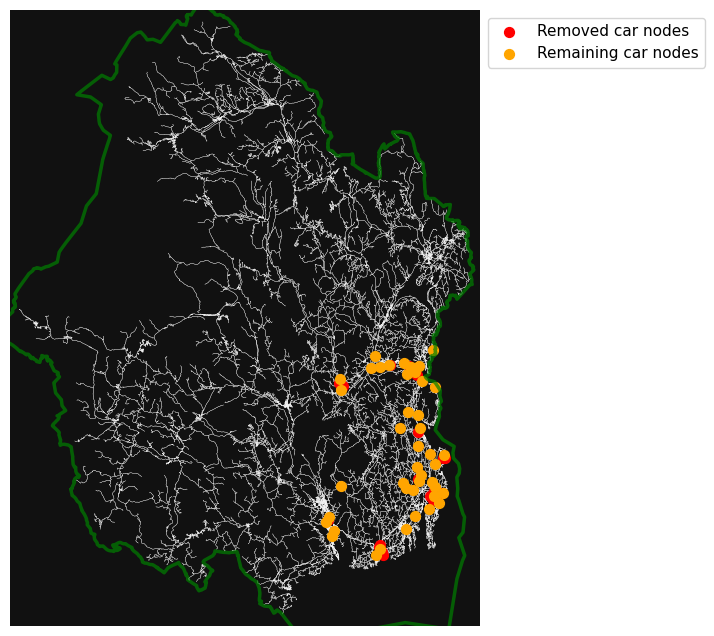

Input nr of car nodes: 64
Remaining nr of car nodes: 11, after removing the 53 nodes that are within 8000 m of each other



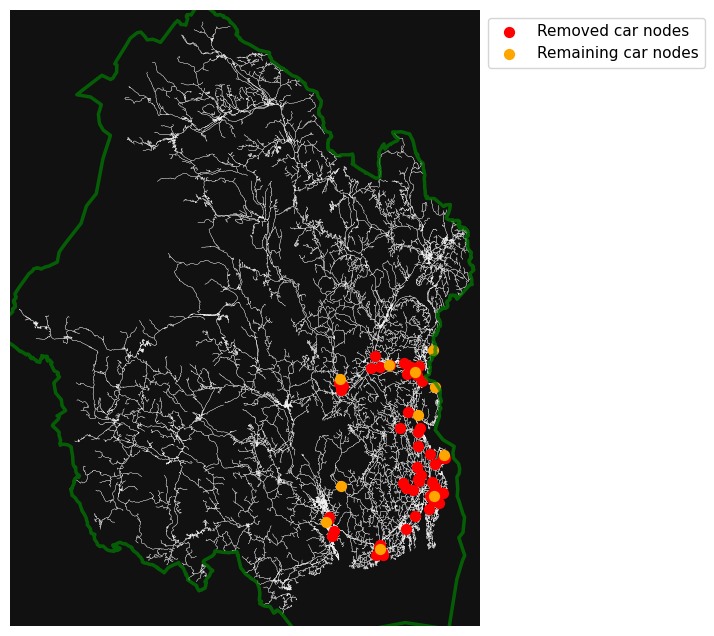

In [64]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=SouthEast_polygon_gdf, 
                             min_distance=2000, input_graph=SouthEast_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=SouthEast_polygon_gdf, min_distance=8000, 
                                input_graph=SouthEast_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [65]:
# reset index so our origins and destinations are not in index
edges = edges_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed
# nodes = nodes.reset_index()

# create network with pandana
SouthEast_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of SouthEast_network_pdna: {type(SouthEast_network_pdna)}")
print(f"Network nodes:")
SouthEast_network_pdna.nodes_df.head(2)

type of SouthEast_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                          
10302617 170220.120 6542229.281
10302622 170603.539 6542468.624

In [66]:
print(f"Network edges: ")
SouthEast_network_pdna.edges_df.head(2)

Network edges: 


from         to  length  travel_time
0  10302617   10302622 455.109       15.675
1  10302622  836895214 320.376       11.034

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [67]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = SouthEast_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry  nearest_node          x           y
0  POINT (177702.612 6538645.894)    3916301219 177698.236 6538776.578
1  POINT (177358.857 6538536.729)   11581361208 177304.182 6538514.101

In [68]:
# Get list of nearest node ids for event locations
event_nodes_pdna = SouthEast_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = SouthEast_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([ 461357985,  298727787,   63116541, 8712628319, 3834942104],
      dtype=int64)

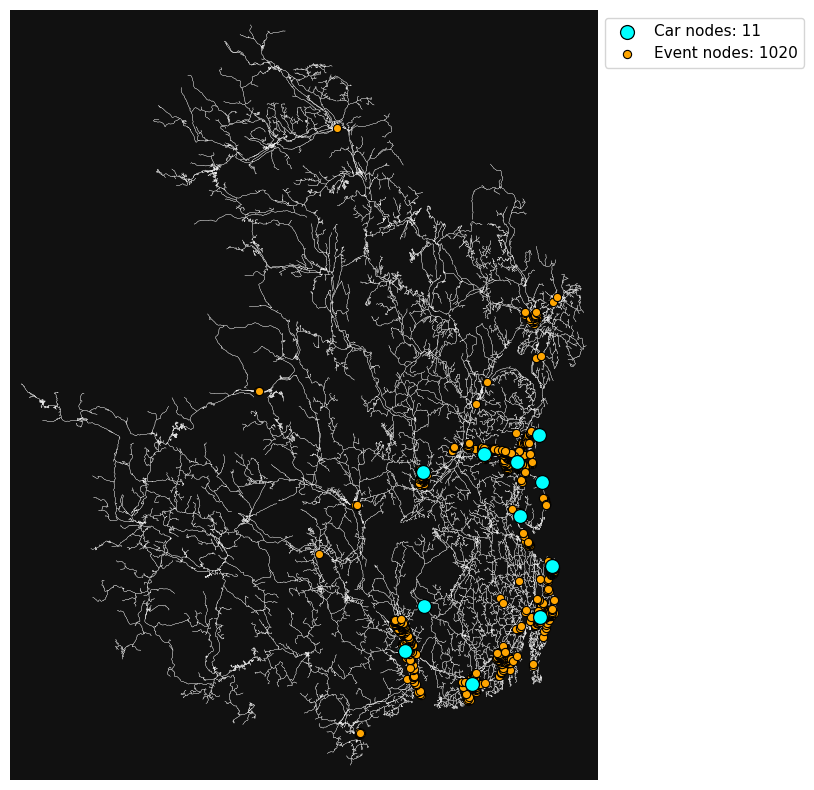

In [69]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(SouthEast_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [70]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [71]:
%%time
# travel time between each possible pair of car-event combination
distances = SouthEast_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = SouthEast_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

11 origins x 1020 destinations = 11220 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [102557.783, 102790.687, 102329.256, 102402.898, 102717.429]
5 first origin-destination travel times [sec]: [3228.175, 3251.53, 3205.259, 3212.643, 3244.184]
CPU times: total: 594 ms
Wall time: 93.3 ms


In [72]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times) / 60 # in minutes
travel_times_df.describe().T

count   mean    std   min    25%    50%    75%     max
0 11220.000 34.353 18.864 0.174 19.117 33.547 47.794 159.694

In [73]:
# Restructure the distances and travel times arrays into a DataFrame (CSouthEast Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time  carNodeID  eventNodeID          x           y
0 102557.783     3228.175  461357985   3916301219 177698.236 6538776.578
1 102790.687     3251.530  461357985  11581361208 177304.182 6538514.101

In [74]:
# Save cSouthEast matrix to CSV
CostMatrix.to_csv("../data/SouthEast/SouthEastCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [75]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time  carNodeID    eventNodeID
0     3228.175  461357985   3916301219_1
1     3251.530  461357985  11581361208_1

In [76]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
margin = len(event_nodes_pdna) * 0.03 # 3% of all events
CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 286 events per car
Filtering out 0% highest travel times - keeping only travel times <= 9582 sec, or 159.7 min
Original nr of pairs: 11220 | Filtered nr of pairs: 11220
Original max travel time: 9581.649 | Filtered max travel time: 9581.649


### 5.2 Setup LP problem

In [77]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 11
Number of events: 1020
Number of decision variables: 11231
Number of constraints: 12252
Number of non-zero coefficients: 11231
Number of non-zero coefficients in the objective function: 11220
CPU times: total: 250 ms
Wall time: 543 ms


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).


In [78]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
PULP_CBC_CMD with LP relaxation found 3/4 locations in 1.04 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 10.13 seconds: [461357985 298727787 261281804 658469453]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 650054.1480 seconds, or 10834.24 minutes, or 180.57 hours
CPU times: total: 656 ms
Wall time: 11.7 s


### 5.6 Extract results for inspection

In [79]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/SouthEast/SouthEastCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Optimal police car locations: dict_keys([461357985, 298727787, 261281804, 658469453])
Car 461357985 is assigned 286/286 events
Car 298727787 is assigned 278/286 events
Car 261281804 is assigned 286/286 events
Car 658469453 is assigned 170/286 events
Summing the events for each car gives 1020 events, which should equal the total number of unique events: 1020


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 11 | Optimal locations in solution: 4
- Events: 1020 | Max event capacity per police car: 286

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 650054 sec | 10834.2 min | 180.57 hours

Car id: 461357985 handles 286 events | Capacity: 100.00% | Total response time: 2969.63 min | Median: 13.37 min | Avg: 10.38 min
Car id: 298727787 handles 278 events | Capacity: 97.20% | Total response time: 3177.27 min | Median: 9.32 min | Avg: 11.43 min
Car id: 261281804 handles 286 events | Capacity: 100.00% | Total response time: 2803.43 min | Median: 5.04 min | Avg: 9.80 min
Car id: 658469453 handles 170 events | Capacity: 59.44% | Total response time: 1883.90 min | Median: 6.26 min | Avg: 11.08 min


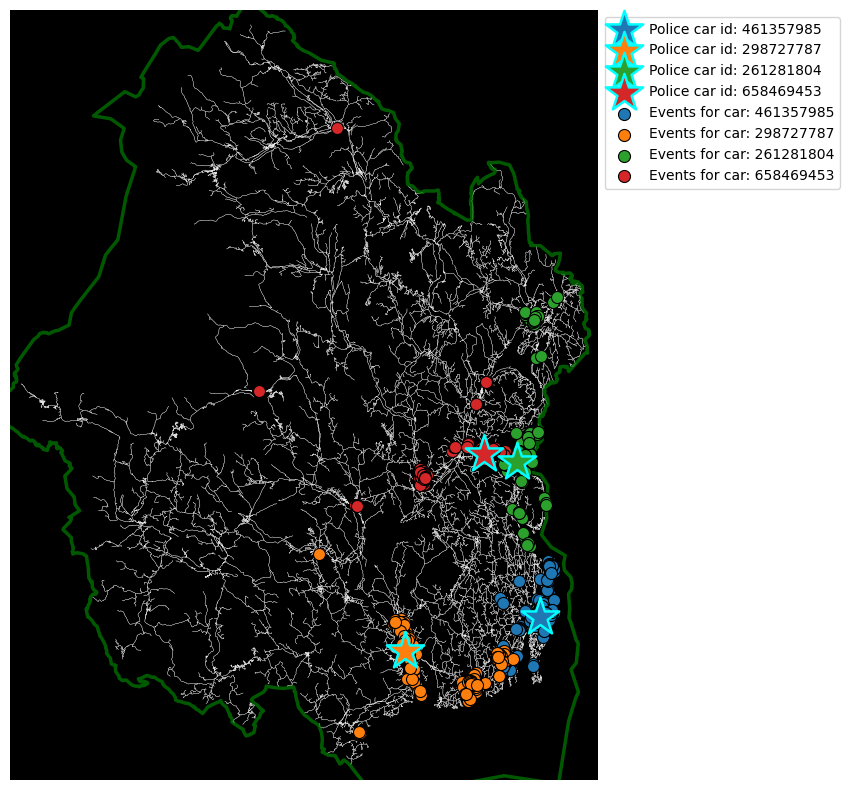

CPU times: total: 5.73 s
Wall time: 9.13 s


In [80]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(SouthEast_graph, SouthEast_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [81]:
# Define how many trip times to visualize
TRIP_TIMES = [15, 60, 120]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [82]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(SouthEast_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=400, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 3min 32s
Wall time: 4min 48s


Isochrone polygons for the travel times: [15, 60, 120] minutes


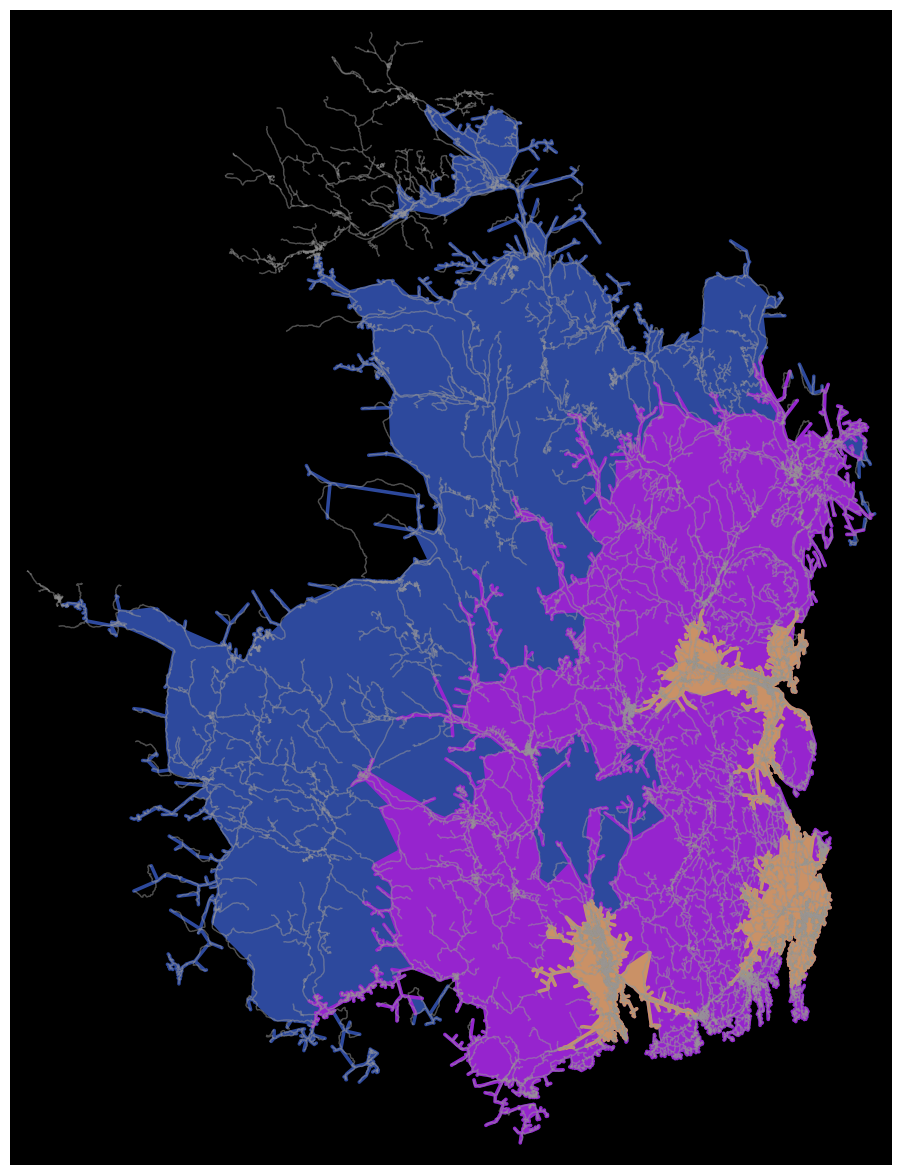

In [83]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(SouthEast_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [85]:
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(SouthEast_graph_increased, TRIP_TIMES, merged_isochrones, SouthEast_polygon_gdf, background_poly=True)
isochrone_map